In [ ]:
%load_ext autoreload
%autoreload 2
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from visualization_tool.visualization_pipe import FeatureExtractor, VisualizationPipe

# 1. Set up the core components
# Use a small model for quick testing.
model_name = "meta-llama/Llama-2-7b-hf" #"meta-llama/Llama-3.1-8B" #"meta-llama/Llama-3.1-8B" #  "Qwen/Qwen2.5-0.5B"
feature_extractor = FeatureExtractor(model_name=model_name)
viz_manager = VisualizationPipe(extractor=feature_extractor)

# 2. Define the visualization parameters
task = "The quick brown fox jumps over the lazy dog."
task = "Call me Ishmael. Some years ago—never mind how long precisely—having little or no money in my purse, and nothing particular to interest me on shore, I thought I would sail about a little and see the watery part of the world."#It is a way I have of driving off the spleen and regulating the circulation. Whenever I find myself growing grim about the mouth; whenever it is a damp, drizzly November in my soul; whenever I find myself pausing before coffin warehouses, and bringing up the rear of every funeral I meet; and especially whenever my hypos get such an upper hand of me, that it requires a strong moral principle to prevent me from deliberately stepping into the street, and methodically knocking people’s hats off—then, I account it high time to get to sea as soon as I can. This is my substitute for pistol and ball. With a philosophical flourish Cato throws himself upon his sword; I quietly take to the ship. There is nothing surprising in this. If they but knew it, almost all men in their degree, some time or other, cherish very nearly the same feelings towards the ocean with me."
context = ""

# 3. Run the pipeline
# The 'load' step is the expensive one, performing the forward pass.
viz_manager.load(tasks=task, contexts=context)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading model: meta-llama/Llama-3.1-8B


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model and tokenizer loaded successfully.
Encoding prompts and extracting features...
Features loaded and cached successfully.


HeatmapConfig(title='Attention Map', show_cbar=False, normalize_cmap=False, x_labels=['Head: mean(0~31)'], y_labels=['Layer: mean(0~31)'], x_ticks=['Call', ' me', ' Ish', 'ma', 'el', '.', ' Some', ' years', ' ago', '—', 'never', ' mind', ' how', ' long', ' precisely', '—', 'having', ' little', ' or', ' no', ' money', ' in', ' my', ' purse', ',', ' and', ' nothing', ' particular', ' to', ' interest', ' me', ' on', ' shore', ',', ' I', ' thought', ' I', ' would', ' sail', ' about', ' a', ' little', ' and', ' see', ' the', ' wat', 'ery', ' part', ' of', ' the', ' world', '.'], y_ticks=['Call', ' me', ' Ish', 'ma', 'el', '.', ' Some', ' years', ' ago', '—', 'never', ' mind', ' how', ' long', ' precisely', '—', 'having', ' little', ' or', ' no', ' money', ' in', ' my', ' purse', ',', ' and', ' nothing', ' particular', ' to', ' interest', ' me', ' on', ' shore', ',', ' I', ' thought', ' I', ' would', ' sail', ' about', ' a', ' little', ' and', ' see', ' the', ' wat', 'ery', ' part', ' of', '

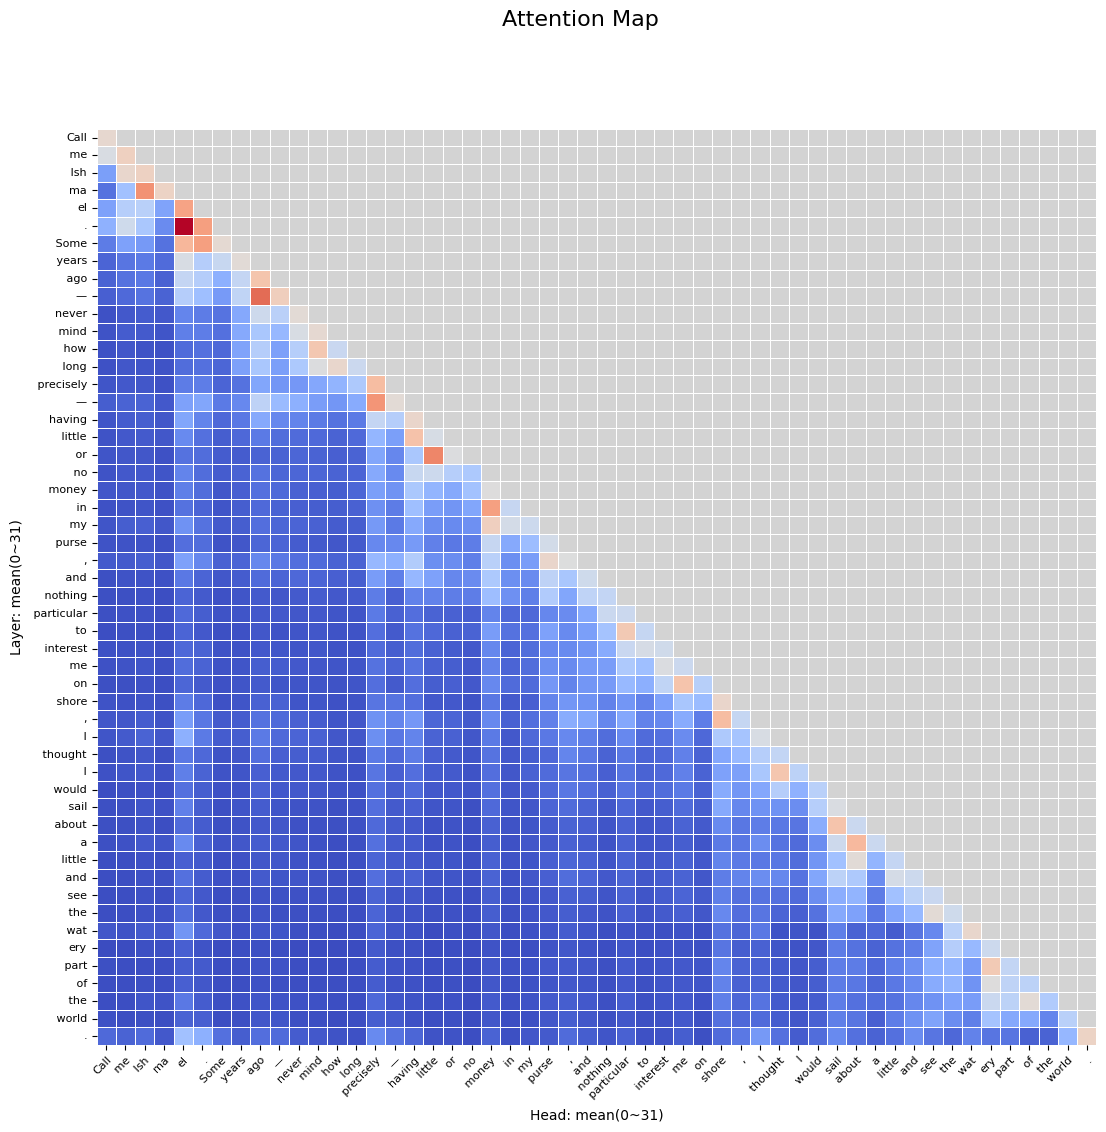

In [3]:
viz_manager.plot('attention_heatmap')

tensor(1)
tensor(2)
torch.Size([1, 2, 52, 32])
HeatmapConfig(title='Attention Map', show_cbar=False, normalize_cmap=False, x_labels=['Offset: 1', 'Offset: 2'], y_labels=['Layer: 0'], x_ticks=[], y_ticks=['Call', ' me', ' Ish', 'ma', 'el', '.', ' Some', ' years', ' ago', '—', 'never', ' mind', ' how', ' long', ' precisely', '—', 'having', ' little', ' or', ' no', ' money', ' in', ' my', ' purse', ',', ' and', ' nothing', ' particular', ' to', ' interest', ' me', ' on', ' shore', ',', ' I', ' thought', ' I', ' would', ' sail', ' about', ' a', ' little', ' and', ' see', ' the', ' wat', 'ery', ' part', ' of', ' the', ' world', '.'], rotate_x_labels_degree=None)


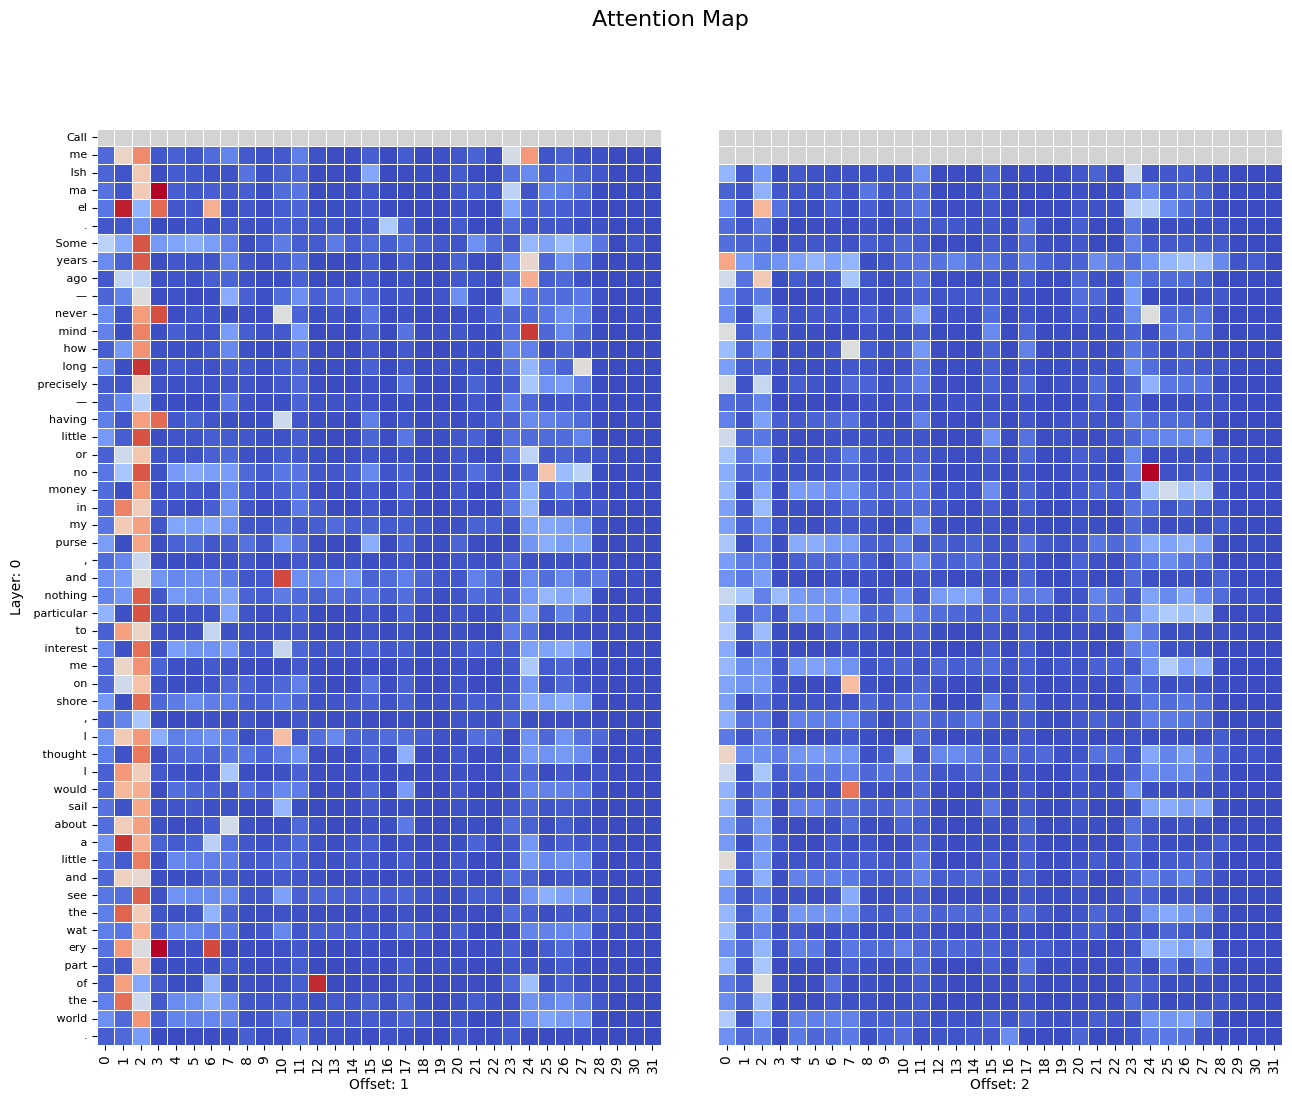

In [4]:
viz_manager.plot('pref_attn_heatmap', target_layers = [0], pref_token_offset=[1, 2])

torch.Size([2, 5, 6, 32])
HeatmapConfig(title='Attention Map', show_cbar=False, normalize_cmap=False, x_labels=['Layer: 0', 'Layer: 5', 'Layer: 10', 'Layer: 15', 'Layer: 20'], y_labels=['Target:  years', 'Target:  how'], x_ticks=range(0, 32), y_ticks=range(-5, 1), rotate_x_labels_degree=None)


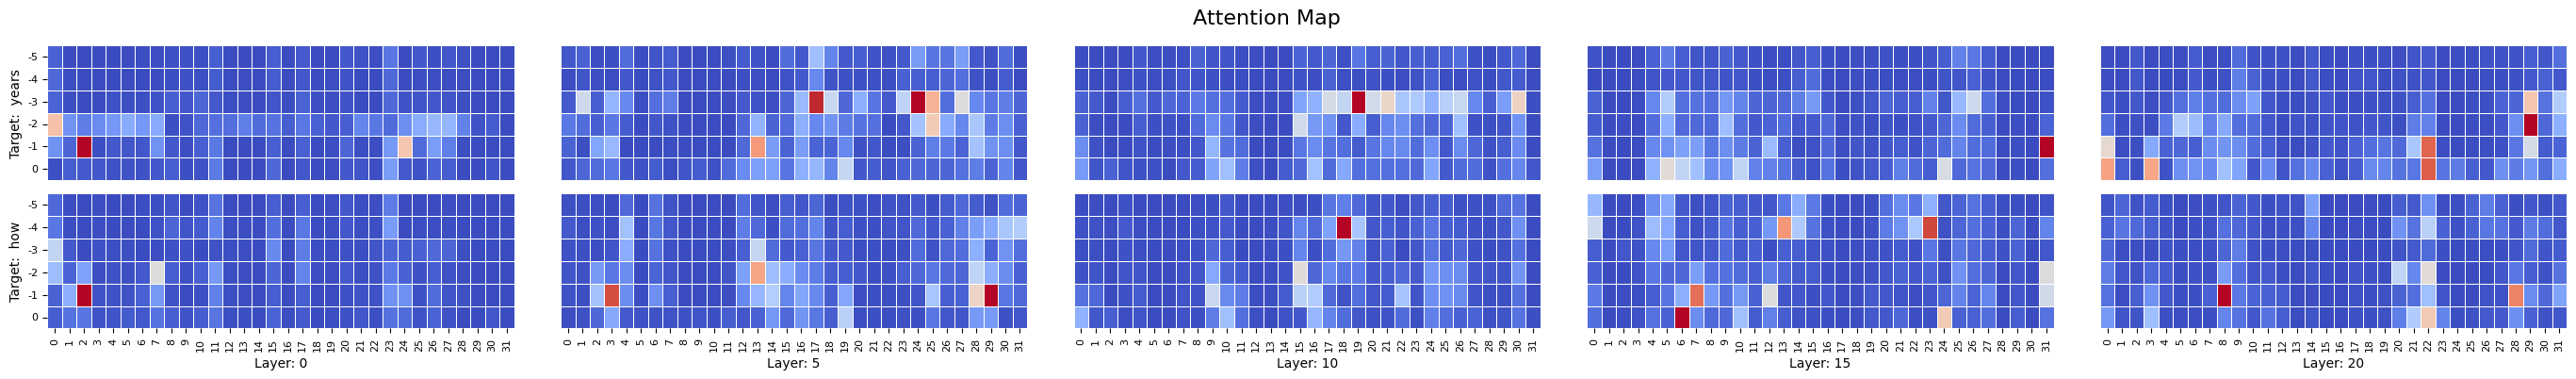

In [5]:
viz_manager.plot('attn_from_heatmap', target_layers = slice(0, 23, 5), target_tokens=[8, 13], num_pref_token = 5)

In [12]:
import torch
from torch import Tensor
from base_classes import FeatureProcessor, FeatureCache
from typing import Dict, Union, List, Any, Optional, Callable
    
class AggFutAttnProcessor(FeatureProcessor):
    """
    Processes attention weights from a FeatureCache.

    This processor can select specific layers, heads, and tokens, and then
    aggregate the resulting attention maps using a specified method (e.g., mean, max).
    """
    
    def __init__(self, 
                 tokenizer: Any, 
                 target_layers: Optional[Union[int, slice, List[int]]] = None, 
                 target_heads: Optional[Union[int, slice, List[int]]] = None, 
                 target_tokens: Optional[Union[int, slice, List[int]]] = None,
                 attn_aggregation_method: Optional[str] = 'mean',
                 aggregation_method: Optional[str] = 'mean', **kwargs):
        """
        Initializes the AttentionProcessor.

        Args:
            tokenizer: A Hugging Face tokenizer instance.
            target_layers: The layer(s) to select. Can be an int, slice, or list of ints.
                           If None, all layers are used.
            target_heads: The head(s) to select. Can be an int, slice, or list of ints.
                          If None, all heads are used.
            target_tokens: The token(s) to select. Can be an int, slice, or list of ints.
                           If None, all tokens from the 'task_mask' are used.
            aggregation_method: How to aggregate attentions across selected layers/heads.
                                Options: 'mean', 'max', or None (no aggregation).
        """
        super().__init__(tokenizer)
        self.target_layers_spec = target_layers
        self.target_heads_spec = target_heads
        self.target_tokens_spec = target_tokens
        self.aggregation_method = aggregation_method
        self.attn_aggregation_method = attn_aggregation_method
        
        self.aggregation_mapping: Dict[str, Callable] = {
            'mean': lambda x, dim: torch.mean(x, dim=dim, keepdim=True),
            'max': lambda x, dim: torch.max(x, dim=dim, keepdim=True).values
        }
        self.aggregation_fn = self.aggregation_mapping.get(aggregation_method) if aggregation_method else None
        self.attn_aggregation_fn = self.aggregation_mapping.get(attn_aggregation_method) if attn_aggregation_method else None
            
    @staticmethod
    def _create_target_tensor(target_spec: Optional[Union[int, slice, List[int]]], max_val: int) -> Union[Tensor, List[Tensor]]:
        """Converts a flexible target specification into a 1D tensor of indices."""
        if target_spec is None:
            return torch.arange(max_val)
        if isinstance(target_spec, int):
            return torch.tensor([target_spec])
        if isinstance(target_spec, slice):
            start = target_spec.start or 0
            stop = target_spec.stop or max_val
            step = target_spec.step or 1
            return torch.arange(start, stop, step)
        if isinstance(target_spec, list) and all([isinstance(item, int) for item in target_spec]):
            return torch.tensor(target_spec)
        if isinstance(target_spec, list):
            group_specs = []
            for item in target_spec:
                if isinstance(item, int):
                    group_specs.append(torch.tensor([item]))
                elif isinstance(item, slice):
                    start = item.start or 0
                    stop = item.stop or max_val
                    step = item.step or 1
                    group_specs.append(torch.arange(start, stop, step))
                elif isinstance(item, list) and all([isinstance(el, int) for el in item]):
                    group_specs.append(torch.tensor(item))
                else:
                    raise TypeError(f"Unsupported element type in list: {type(item)}")
            return group_specs
        else:
            raise TypeError(f"Unsupported target type: {type(target_spec)}")
        
    def _select_target_tensor(self, cache_tensor, dim, target_tensor):
        
        if isinstance(target_tensor, Tensor):
            return torch.index_select(cache_tensor, dim, target_tensor)
        
        selcted_cache = []
        if not self.aggregation_fn:
            raise ValueError('The aggregation function must be defined.')
        for target_group in target_tensor:
            selcted_cache.append(
                self.aggregation_fn(
                  torch.index_select(cache_tensor, dim, target_group)   
                , dim)
            )
        return torch.cat(selcted_cache, dim=dim)
       
    def process(self, inputs: Dict[str, Tensor], residual_cache: FeatureCache) -> Dict[str, Any]:
        """
        Selects, aggregates, and formats attention weights for plotting.
        """
        # 1. Prepare the full attention tensor
        all_attentions = torch.stack(list(residual_cache.attentions.values())).squeeze(1) #  (num_layers, num_heads, seq_len, seq_len)
        if len(all_attentions.shape) != 4:
            raise NotImplementedError
        
        # 2. Resolve target indices
        target_layers = self._create_target_tensor(self.target_layers_spec, residual_cache.num_layers)
        target_heads = self._create_target_tensor(self.target_heads_spec, residual_cache.num_heads)
        
        # Determine target tokens from the task mask if not specified
        if self.target_tokens_spec is None:
            # Assuming a single sample for token selection if batch size > 1 -> TODO
            # Use the mask of the first sample to determine the token indices
            task_mask_for_tokens = inputs['task_mask'][0]
            target_tokens = torch.where(task_mask_for_tokens)[0]
        else:
            seq_len = all_attentions.shape[-1]
            target_tokens = self._create_target_tensor(self.target_tokens_spec, seq_len)

        # 3. Perform selection and aggregation with vectorized operations

        selected_attns = self._select_target_tensor(all_attentions, 0, target_layers)
        selected_attns = self._select_target_tensor(selected_attns, 1, target_heads)
        
        # Aggregate across layers and heads if an aggregation function is specified
        offset = 10
        final_matrix = selected_attns[:, :, target_tokens, :][:, :, :, target_tokens]
        offset_mask=(torch.tril(torch.ones_like(final_matrix)) - torch.tril(torch.ones_like(final_matrix), diagonal=-offset)).bool()
        final_matrix[~offset_mask] = 0
        final_matrix = final_matrix / final_matrix.sum(-1, keepdim=True)
        final_matrix = final_matrix.sum(-2) /  offset
        final_matrix[:,:,-offset:] = torch.nan
        final_matrix = final_matrix.unsqueeze(0).permute(0, 1, 3, 2)
        print(final_matrix.shape)
            
        # 4. Prepare output for the plotter
        attn_matrix_np = final_matrix.cpu().float().numpy()

        # Create Axies Labels
        # if isinstance(target_tokens, Tensor):
        #     target_ids = target_tokens.tolist()
        #     target_label = [self.tokenizer.decode(inputs['input_ids'][0][id]) for id in target_ids]
        # else:
        #     raise NotImplementedError
        #     target_label = [f"{self.aggregation_method}({group[0]}~{group[-1]})" for group in target_tokens]
            
        if isinstance(target_layers, Tensor):
            layer_labels = target_layers.tolist()
        else:
            layer_labels = [f"{self.aggregation_method}({group[0]}~{group[-1]})" for group in target_layers]
               
        # Create token labels for plot ticks
        tick_labels = self._create_labels_from_ids(inputs['input_ids'][0], inputs['task_mask'][0])
        # filtered_labels = [tick_labels[i] for i in range(len(tick_labels)) if torch.any(target_tokens == i)]

        # The generic output dictionary, decoupled from any specific plotter
        return {
            "data": {
                "data_matrix": attn_matrix_np
            },
            "config": {
                "title": "Attention Map",
                "y_ticks": tick_labels,
                "x_ticks": range(len(target_heads)),
                # "y_labels": [f"Target: {h}" for h in target_label],
                "x_labels": [f"Layer: {l}" for l in layer_labels],
            }
        }
processor = AggFutAttnProcessor(
    tokenizer=viz_manager.tokenizer,
    target_layers=[slice(0, 5), slice(5, 10), slice(10,15), slice(15,20), slice(20,25), slice(25,30), slice(30,32)],
    target_heads=[slice(0,32)]
)

torch.Size([1, 7, 52, 1])
HeatmapConfig(title='Attention Map', show_cbar=False, normalize_cmap=False, x_labels=['Layer: mean(0~4)', 'Layer: mean(5~9)', 'Layer: mean(10~14)', 'Layer: mean(15~19)', 'Layer: mean(20~24)', 'Layer: mean(25~29)', 'Layer: mean(30~31)'], y_labels=[], x_ticks=range(0, 1), y_ticks=['Call', ' me', ' Ish', 'ma', 'el', '.', ' Some', ' years', ' ago', '—', 'never', ' mind', ' how', ' long', ' precisely', '—', 'having', ' little', ' or', ' no', ' money', ' in', ' my', ' purse', ',', ' and', ' nothing', ' particular', ' to', ' interest', ' me', ' on', ' shore', ',', ' I', ' thought', ' I', ' would', ' sail', ' about', ' a', ' little', ' and', ' see', ' the', ' wat', 'ery', ' part', ' of', ' the', ' world', '.'], rotate_x_labels_degree=None)


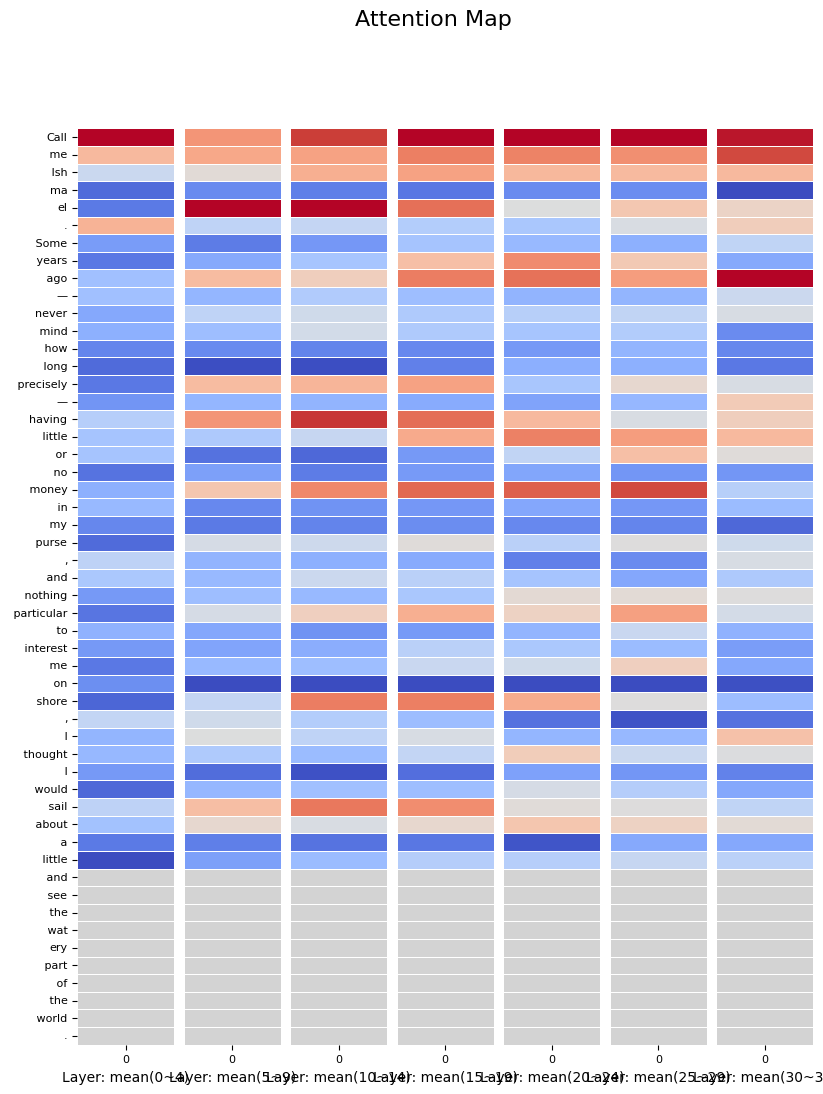

In [13]:
from plotters import HeatmapPlotter, HeatmapData, HeatmapConfig

viz_manager._process_plot(
    feat_processor=processor,
    feat_plotter=HeatmapPlotter(),
    plot_data_class=HeatmapData,
    plot_config_class=HeatmapConfig,
)

Top 10 predicted tokens at layer 0:
Position 0 ('<|begin_of_text|>'): ['greg', 'utron', '784', '_lineno', '783', 'ister', 'れど', '�', 'ulet', 'otron']
Position 1 ('Call'): ['ux', '.Hand', 'oo', ' hand', 'ous', 'ua', 'up', ' Welfare', 'usk', ' sm']
Position 2 (' me'): ['LEAR', 'acock', 'atro', ' Norman', 'libft', ' offsetX', 'ewear', 'ilip', '�', 'hev']
Position 3 (' Ish'): ['�', 'ugen', 'imple', 'ette', 'aded', 'ettes', 'らし', 'clusive', 'caps', 'iola']
Position 4 ('ma'): ['anki', 'аки', 'anken', 'heiro', '빌', 'asaki', 'ergus', 'LookAndFeel', 'rena', '_HOT']
Position 5 ('el'): ['uevo', ' Paige', 'cheng', '719', 'ewan', 'odox', ' Rowe', 'hub', ' magnets', 'urma']
Position 6 ('.'): ['ysi', 'iaux', 'idon', 'ican', 'ethyst', ' Pun', ' Pension', 'ersions', 'ysz', '�']
Position 7 (' Some'): ['place', 'ones', 'hone', 'ipeline', 'Sizer', 'ату', 'ions', 'ome', ' Sor', 'ullen']
Position 8 (' years'): ['ano', 'pper', 'φο', 'ROTO', 'REAM', 'odash', ' Anthem', 'itudes', 'GLOBALS', 'wner']
Position 9 

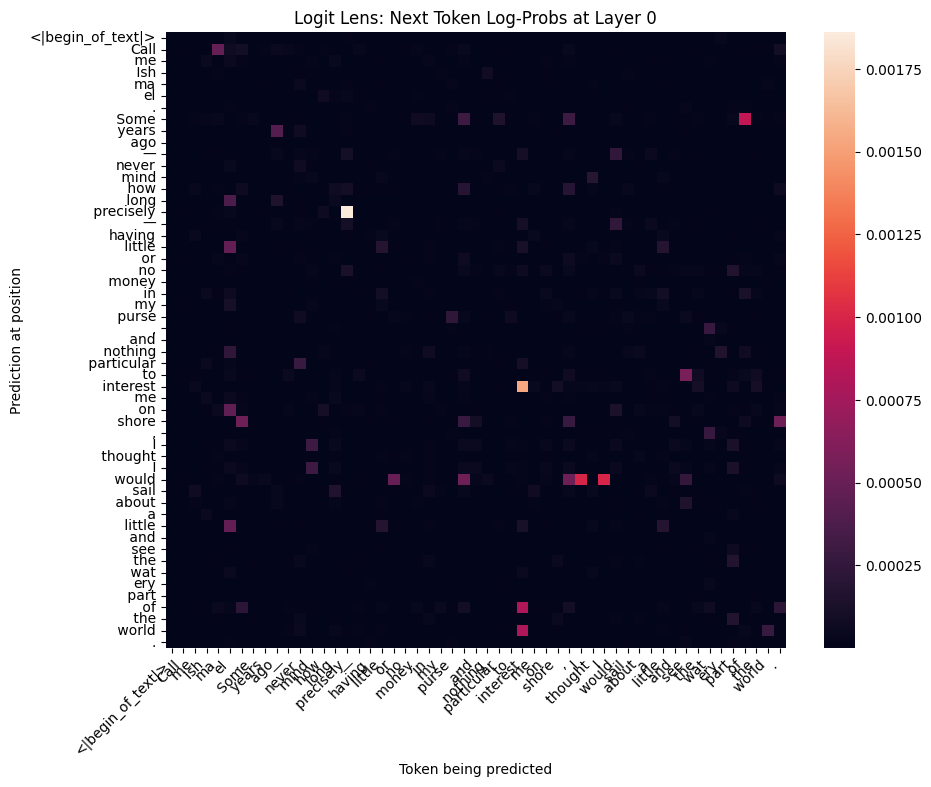

In [29]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# --- Setup ---
norm = viz_manager.extractor.model.model.norm
lm_head = viz_manager.extractor.model.lm_head
tokenizer = viz_manager.tokenizer
hddn = viz_manager.feature_cache.hidden_states
input_ids = viz_manager.inputs['input_ids'][0]
device = viz_manager.extractor.device

layer = 0
hddn_at_layer = hddn[layer]
# norm = lambda x: x

# --- Calculation ---
# Project the intermediate hidden state to get raw logits
raw_logits = lm_head(norm(hddn_at_layer.squeeze().to(device)))

# --- Top-K Analysis ---
print(f"Top 10 predicted tokens at layer {layer}:")
# Get topk from raw_logits, the indices will be the same
top_k_indices = torch.topk(raw_logits, 10).indices

for i, tokens in enumerate(top_k_indices):
    decoded_tokens = [tokenizer.decode(tok) for tok in tokens]
    print(f"Position {i} ({tokenizer.decode(input_ids[i])!r}): {decoded_tokens}")

# --- Heatmap Visualization ---
# Use log_softmax for better numerical stability and directness
log_probs = torch.softmax(raw_logits, dim=-1)

# Select the log probabilities of the original input tokens
heatmap_data = log_probs[:, input_ids].detach().cpu().float().numpy()

# Plotting
tick_labels = [tokenizer.decode(tok).replace(' ', ' ') for tok in input_ids]
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    xticklabels=tick_labels,
    yticklabels=tick_labels,
)
plt.xlabel("Token being predicted")
plt.ylabel("Prediction at position")
plt.title(f"Logit Lens: Next Token Log-Probs at Layer {layer}")
plt.xticks(rotation=45, ha="right")
plt.show()

In [26]:
hddn_at_layer.shape

torch.Size([1, 53, 4096])

In [10]:
t = torch.randn(11, 128256)
i = torch.tensor([2, 3, 41])
t[:, i]

tensor([[-0.5422, -0.9781,  0.3008],
        [-0.3566,  2.1570,  1.2405],
        [-0.9270, -1.5089,  0.4835],
        [ 0.7216,  3.3933,  1.1049],
        [-0.4814,  0.7349, -0.2579],
        [ 1.0737, -0.4246,  0.2098],
        [ 0.4847,  0.9312, -1.0472],
        [-0.8249,  0.1260, -0.7232],
        [ 1.5224,  0.5643,  1.3229],
        [ 1.9368,  0.4147, -0.4529],
        [-0.6363,  0.0694,  0.2792]])